## Purpose
Original repo: [DeepLearning-FromPaper](https://github.com/NinaM31/DeepLearning-FromPaper).    

This is my implementation of [Deep Convolutional Generative Adversarial Networks (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf) paper, on the monet problem.

# Imports

In [11]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [12]:
import random
import numpy as np
import torch

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Custom Dataset

In [13]:
class Dataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB')
        return self.transform(img)

# Discriminator Class

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

# Generator Class

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

# DCGAN Class

In [16]:
class DCGAN:

    def __init__(self, z_size, conv_dim):
        self.z_size = z_size

        self.D = Discriminator(conv_dim)
        self.G = Generator(z_size, conv_dim)

        # self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = torch.device("mps")
    
        self.D.to(self.device)
        self.G.to(self.device)

        self.D.apply(self.weights_init)
        self.G.apply(self.weights_init)

        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

            
    def describe(self):
        print('Discriminator')
        print(self.D)

        print('\nGenerator')
        print(self.G)

    
    def __calculate_loss(self, output, labels):
        criterion = nn.BCELoss()
        return criterion(output.squeeze(), labels)


    def real_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.8

        return self.__calculate_loss(D_out, labels) 


    def fake_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.1
 
        return self.__calculate_loss(D_out, labels)


    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float().to(self.device)


    def train_generator(self, g_optim, size):
        g_optim.zero_grad()

        z = self.noise(size)
        fake_images = self.G(z)
        
        d_fake = self.D(fake_images)

        g_loss = self.real_loss(d_fake)

        g_loss.backward()
        g_optim.step()

        return g_loss.item()

    
    def train_discriminator(self, d_optim, real_images, size):
        d_optim.zero_grad()

        d_real = self.D(real_images.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)

        z = self.noise(size)
        fake_images = self.G(z)
      
        d_fake = self.D(fake_images)
        d_fake_loss = self.fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optim.step()

        return d_loss.item()


    def train(self, num_epochs, d_optim, g_optim, data_loader, z_size, sample_size, print_every=500):
        samples, losses = [], []

        z = self.noise((sample_size, z_size))

        self.D.train()
        self.G.train()

        print(f'Running on {self.device}')
        for epoch in range(num_epochs):
            for i, real_images in enumerate(data_loader):                    
                batch_size = real_images.size(0)

                d_loss = self.train_discriminator(d_optim, real_images, (sample_size, z_size))
                g_loss = self.train_generator(g_optim, (sample_size, z_size))

                if i % print_every == 0:
                    print('Epoch [{:5d}/{:5d}] | d_loss {:6.4f} | g_loss {:6.4f}'.format(
                        epoch+1,
                        num_epochs,
                        d_loss,
                        g_loss
                    ))

            losses.append( (d_loss, g_loss) )

            self.G.eval()
            samples.append( self.G(z) )
            self.G.train()

        with open('DCGAN_Sample_Output.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return samples, losses 

# Let's Generate Art


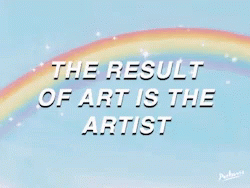

In [17]:
DATA_DIR = './data/monet/training/monet_jpg'

BATCH_SIZE = 16
N_WORKERS = 0

Z_SIZE = 128
SAMPLE_SIZE = 16
CONV_DIM = 64

lr = 0.0002
beta1=0.5
beta2=0.999

EPOCHS = 500

In [18]:
# Dataset
monet_dataset = Dataset(DATA_DIR)
data_loader = DataLoader(monet_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)


# Model
dcgan_model = DCGAN(Z_SIZE, CONV_DIM)

# Oprimizer
d_optimizer = optim.Adam(dcgan_model.D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(dcgan_model.G.parameters(), lr, [beta1, beta2])

# train
sample_result, losses_history = dcgan_model.train(EPOCHS, d_optimizer, g_optimizer, data_loader, Z_SIZE, SAMPLE_SIZE, print_every=1000)

Running on mps
Epoch [    1/  500] | d_loss 2.1248 | g_loss 3.7308
Epoch [    2/  500] | d_loss 1.4308 | g_loss 6.2681
Epoch [    3/  500] | d_loss 1.2430 | g_loss 6.4436
Epoch [    4/  500] | d_loss 1.1849 | g_loss 5.4180
Epoch [    5/  500] | d_loss 1.0777 | g_loss 3.3837
Epoch [    6/  500] | d_loss 1.0052 | g_loss 1.5393
Epoch [    7/  500] | d_loss 0.9773 | g_loss 2.9219
Epoch [    8/  500] | d_loss 1.4371 | g_loss 7.8501
Epoch [    9/  500] | d_loss 0.9385 | g_loss 2.6282
Epoch [   10/  500] | d_loss 0.9515 | g_loss 3.0280
Epoch [   11/  500] | d_loss 0.9552 | g_loss 2.8808
Epoch [   12/  500] | d_loss 0.9751 | g_loss 1.8410
Epoch [   13/  500] | d_loss 1.0587 | g_loss 2.1348
Epoch [   14/  500] | d_loss 1.2349 | g_loss 1.9273
Epoch [   15/  500] | d_loss 1.0699 | g_loss 2.6170
Epoch [   16/  500] | d_loss 1.0831 | g_loss 0.9593
Epoch [   17/  500] | d_loss 1.3615 | g_loss 3.0838
Epoch [   18/  500] | d_loss 0.9381 | g_loss 2.5822
Epoch [   19/  500] | d_loss 0.8585 | g_loss 1.96

# Results

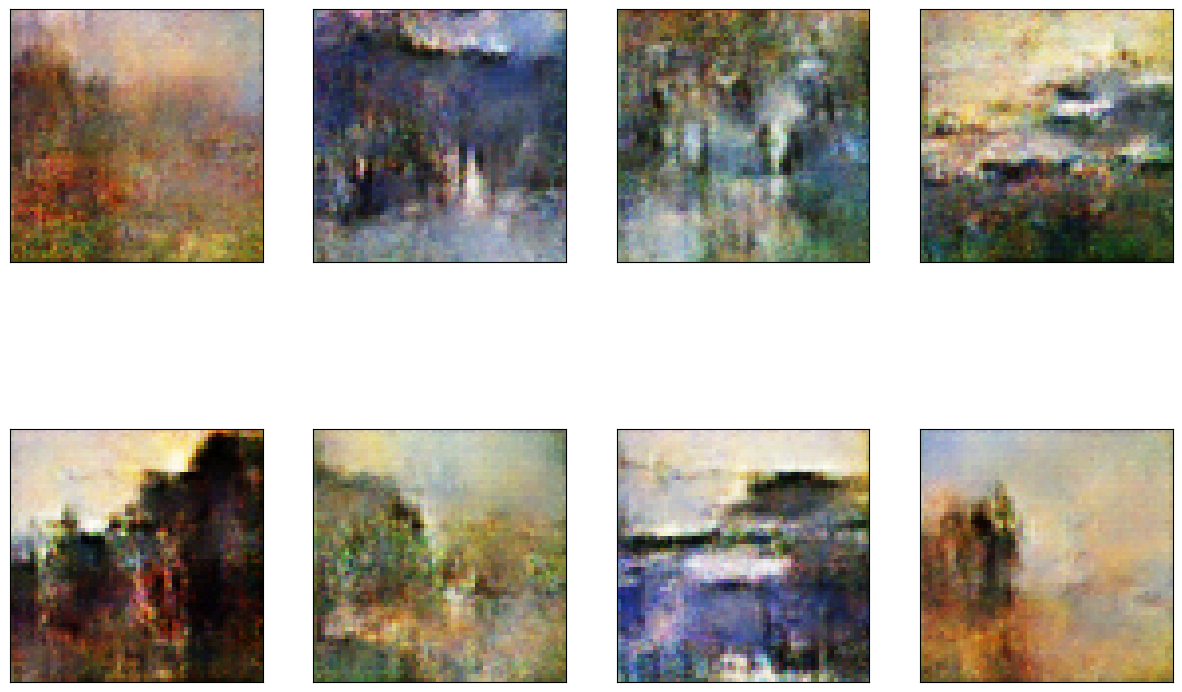

In [19]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), sample_result[EPOCHS-1]):
    _, w, h = img.size()
     
    img = img.detach().cpu().numpy()

    img = np.transpose(img, (1, 2, 0))
    
    img = ((img +1)*255 / (2)).astype(np.uint8)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    im = ax.imshow(img.reshape((w,h,3)))

plt.show()

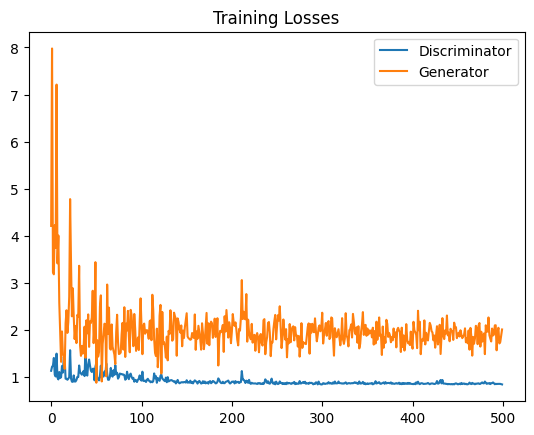

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses_history)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()